In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d imrankhan77/nct-crc-he-100k

100% 11.2G/11.2G [06:18<00:00, 29.0MB/s]
100% 11.2G/11.2G [06:18<00:00, 31.7MB/s]


ADI: Yağ dokusu \
BACK: Histopatolojik görüntülerin arka planı \
DEB: Enkaz, kanser teşhisi için yararlı \
LYM:Lenfositler, lenfatik sistem hücreleri \
MUC:Mukus, doku üzerinde koruyucu tabaka \
MUS:Düz Kas \
NORM: Normal kolon dokusu \
STR: Kanserle ilişkili stroma dokusu \
TUM:Adenokarsinomun epitel dokuları \

In [ ]:
import os, warnings, cv2
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import pandas as pd

from os import listdir
from os.path import isfile, join
from shutil import rmtree

from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification

In [ ]:
!unzip nct-crc-he-100k.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYVEKTQH.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYYPWAIM.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYYQVPLI.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYYRLNYI.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QADCETNL.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QADWKAWV.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAELGSKC.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAEWQKCK.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAFCMDLW.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAGYSSNM.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAHPWERH.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAIQQTEC.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAISCSQV.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAKWPLCE.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QALEPWFA.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QALGHAQL.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAMFQMMD.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAMICSMH.tif  
  inflating: NCT-

In [ ]:
!kaggle datasets download -d madmaxliu/inceptionv3

 94% 73.0M/77.3M [00:02<00:00, 35.9MB/s]
100% 77.3M/77.3M [00:02<00:00, 33.9MB/s]


In [ ]:
!unzip inceptionv3.zip

Archive:  inceptionv3.zip
  inflating: inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [ ]:
yol=r"/content/NCT-CRC-HE-100K"
alt_list=os.listdir(yol)

In [ ]:
veri_df=pd.DataFrame({'ID': [], 'Sinif':[]})

for klasor in alt_list:
    yolum = join(yol,klasor)
    dosyalar=[f for f in listdir(yolum)]
    siniflar=[klasor for c in dosyalar]
    dosya_df = pd.DataFrame({'ID':dosyalar, 'Sinif':siniflar})
    veri_df = veri_df.append(dosya_df)

veri_df

,ID,Sinif
0,MUS-FDYKFKYI.tif,MUS
1,MUS-KHFCHFKT.tif,MUS
2,MUS-FAYFYVGD.tif,MUS
3,MUS-KVPREDAK.tif,MUS
4,MUS-TTDIYRIG.tif,MUS
...,...,...
10441,STR-LVHDLVKW.tif,STR
10442,STR-SPVYSWVV.tif,STR
10443,STR-PSHLPWTV.tif,STR
10444,STR-YYKHGGFF.tif,STR


In [ ]:
veri_df.columns

Index(['ID', 'Sinif'], dtype='object')

In [ ]:
sinif_sayisi = veri_df.Sinif.value_counts()
print('Sınıf sayilari:\n{}'.format(sinif_sayisi[::-1]),'\n','\n')

Sınıf sayilari:
NORM     8763
MUC      8896
ADI     10407
STR     10446
BACK    10566
DEB     11512
LYM     11557
MUS     13536
TUM     14317
Name: Sinif, dtype: int64 
 



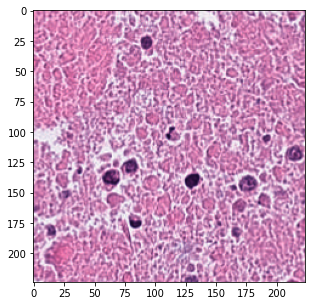

In [ ]:
veri_df.iloc[0][0]
plt.figure(figsize=(5,5))
img = plt.imread(r"/content/NCT-CRC-HE-100K/DEB/DEB-DPETYYLW.tif")
plt.imshow(img)

In [ ]:
x=veri_df["ID"]
y=veri_df["Sinif"]
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.85,random_state=101)

In [ ]:
x_train=pd.DataFrame(x_train)

In [ ]:
x_train.reset_index(drop=True)

,ID
0,TUM-TIWNRRST.tif
1,TUM-CPLRCCRH.tif
2,MUS-FDTNFITH.tif
3,MUS-LMKIRDSI.tif
4,TUM-CQPLLMSE.tif
...,...
84995,MUS-TTEADSTG.tif
84996,LYM-WVVIQIEI.tif
84997,BACK-GRMMLGLW.tif
84998,BACK-MFNGYIWN.tif


In [ ]:
x_test.reset_index(drop=True)
y_train

648       TUM
12577     TUM
10125     MUS
9047      MUS
6276      TUM
         ... 
5695      MUS
6111      LYM
4293     BACK
4479     BACK
1568     NORM
Name: Sinif, Length: 85000, dtype: object

In [ ]:
local_weights_file = r"inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)


for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:

x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.5)(x)                  

x = layers.Dense(9, activation='sigmoid')(x)           


model = Model(pre_trained_model.input, x) 


model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), 
              loss = 'mse', 
              metrics = ['accuracy'])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
y_test=pd.DataFrame(y_test)
y_test.reset_index(drop=True)

,Sinif
0,TUM
1,NORM
2,TUM
3,ADI
4,MUS
...,...
14995,LYM
14996,MUC
14997,TUM
14998,DEB


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio("/content/NCT-CRC-HE-100K", "/content/new",ratio=(0.8,0.2))

Copying files: 100000 files [03:42, 450.14 files/s]


splitfolders.ratio(klasör, çıktı klasör, ratio=(0.8,0.2)
model.fit_generator(train, epochs =200, steps_per_epochs=5, verbose=1,validation_data=val,shuffle=True)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        '/content/new/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical'
        )
test_generator = train_datagen.flow_from_directory(
        '/content/new/val',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical'
        )


Found 79994 images belonging to 9 classes.
Found 20006 images belonging to 9 classes.


In [ ]:
model.fit(train_generator,epochs=10)

NameError: ignored

In [ ]:
model.save("kolon_kanser_siniflandırma")

In [ ]:
model.save("kolon_kanser_siniflandırma.h5",save_format='h5')